# 0.0. Imports

In [322]:
import math
import numpy  as np
import pandas as pd
import random
import requests
import warnings
import inflection
import seaborn as sns
import yfinance as yf
import xgboost as xgb

from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,r2_score
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree          import DecisionTreeRegressor
from datetime import timedelta
from statsforecast  import StatsForecast
from statsforecast.models  import Naive
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima


warnings.filterwarnings( 'ignore' )

## 0.0.1  Help functions

In [323]:
# Função utilizada para calcular o erro dos modelos 

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


## 0.1. Loading data

In [324]:
# Carregando os dados do IBOV
df = pd.read_csv('data_ibov_2.csv')

# 1.0 Data Description

In [326]:
df1 = df.copy()

In [2]:
df1.head()

NameError: name 'df1' is not defined

## 1.2. Data Dimensions

In [1]:
# Verificar as linhas e colunas do df
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

NameError: name 'df1' is not defined

## 1.3. Data Types

In [329]:
df1.dtypes

Data         object
Último      float64
Abertura    float64
Máxima      float64
Mínima      float64
Vol.         object
Var%         object
dtype: object

In [330]:
df1.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,28.12.2023,134.185,134.194,134.389,133.832,"7,81M","-0,01%"
1,27.12.2023,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,26.12.2023,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,22.12.2023,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,21.12.2023,132.182,130.826,132.277,130.822,"8,68M","1,05%"


In [331]:
# Ajustar os dados do df IBOV ( retirar os caracteres de texto das colunas Vol e Var)

df1['Vol.'] = df1['Vol.'].str.replace('M','').str.replace(',','.').str.replace('K','').astype(float)
df1['Var%'] = df1['Var%'].str.replace('%','').str.replace(',','.').astype(float)

df1['Data'] = pd.to_datetime(df1['Data'])


## 1.4. Check NA

In [332]:
# Checar os valores nulos
df1.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

## 1.7. Descriptive Statistics

In [333]:
# Dados Estatístico da base
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Último,2476.0,84.596605,26.455365,37.497,57.6240,85.790,108.80900,134.194
Abertura,2476.0,84.564613,26.445219,37.501,57.6025,85.768,108.79100,134.194
Máxima,2476.0,85.378550,26.614901,38.031,58.0885,86.631,109.88475,134.389
Mínima,2476.0,83.777387,26.271315,37.046,57.0815,85.052,107.88250,133.832
Vol.,2475.0,8.312444,34.137766,1.190,3.5300,4.880,10.21500,980.070
Var%,2476.0,0.051143,1.573083,-14.780,-0.7825,0.055,0.92250,13.910


### 1.7.1. Numerical Atributes

### Neste gráfico de distribuição observamos que não temos uma distribuição simétrica, a maior parte dos dados estão concentrados entre  45mil á 60mil pontos e depois entre 100mil e 115mil 

<AxesSubplot:xlabel='Último'>

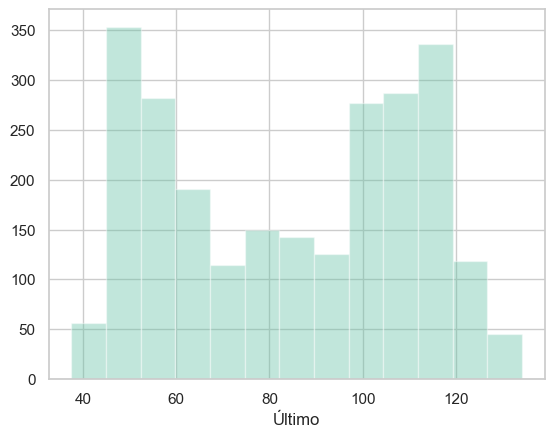

In [334]:

sns.distplot( df1['Último'], kde=False )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [335]:
df2 = df1.copy()

## 2.1. Feature Engineering

### Nesta etapa, acrescentamos mais colunas para representar o dia,mês e ano separadamente para facilitar análises mais especifica como sasonalizade por mês e semana e também para ajudar no desempenho do modelo

In [336]:
df2.set_index('Data', inplace=True)

#year
df2['year'] = df2.index.year

# month
df2['month'] =  df2.index.month

# day
df2['day'] = df2.index.day

# week of year
df2['week_of_year'] = df2.index.weekofyear

# day of week
df2['day_of_week'] = df2.index.day_of_week

df2.dtypes

Último          float64
Abertura        float64
Máxima          float64
Mínima          float64
Vol.            float64
Var%            float64
year              int64
month             int64
day               int64
week_of_year      int64
day_of_week       int64
dtype: object

In [337]:
df2 = df2.loc['2020-01-01':'2023-12-31']

In [338]:
df2.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,year,month,day,week_of_year,day_of_week
Data,,,,,,,,,,,
2023-12-28,134.185,134.194,134.389,133.832,7.81,-0.01,2023,12,28,52,3
2023-12-27,134.194,133.523,134.195,133.328,6.17,0.49,2023,12,27,52,2
2023-12-26,133.533,132.753,133.645,132.753,5.15,0.59,2023,12,26,52,1
2023-12-22,132.753,132.182,133.035,132.094,8.23,0.43,2023,12,22,51,4
2023-12-21,132.182,130.826,132.277,130.822,8.68,1.05,2023,12,21,51,3


## 2.2. Criacao das Hipoteses

**1.** O Desempenho do mercado varia de acordo com o dia da semana ?

**2.** O Mercado apresenta padrões de sazonalidade nos meses ?

**3.** O Desempenho do Mercado é influenciado pelo Volume Financeiro do dia ?

**4.** Qual a tendência do mercado no último ano ?

**5.** O mercado costuma fechar com pontos mais altos no último trimestre ?


# 3.0.  Exploration Data Analisys -  EDA

In [339]:
df3 = df2.copy()

In [340]:
df3['day_of_week'].unique()

array([3, 2, 1, 4, 0, 6, 5], dtype=int64)

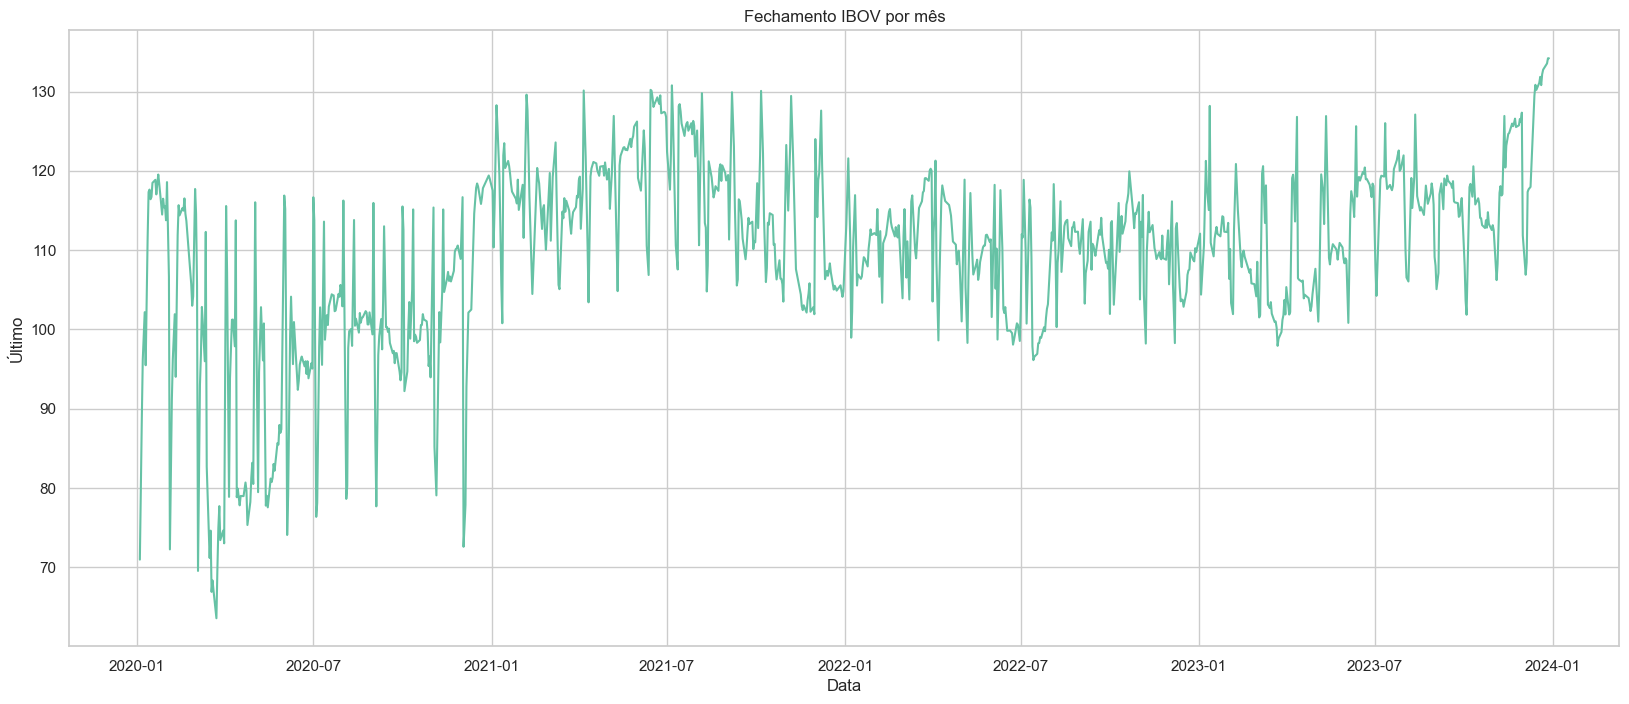

In [341]:
# Exibindo a distribuição do fechamento ao longo do período.
plt.figure(figsize=(20,8))
sns.lineplot(x=df3.index,y='Último',data= df3)
plt.title('Fechamento IBOV por mês')
plt.show()

### Na correlação abaixo, identificamos features que não poderão ser utilizadas no modelo ( Abertura,fechamento, maxima e mínima), pois são informações futuras que são geradas a partir do fechamento do dia. E também observamos que a correlação mais forte com a variável alvo é a coluna "ano" , como já observado tem uma correlação positiva a medida do período analisado.

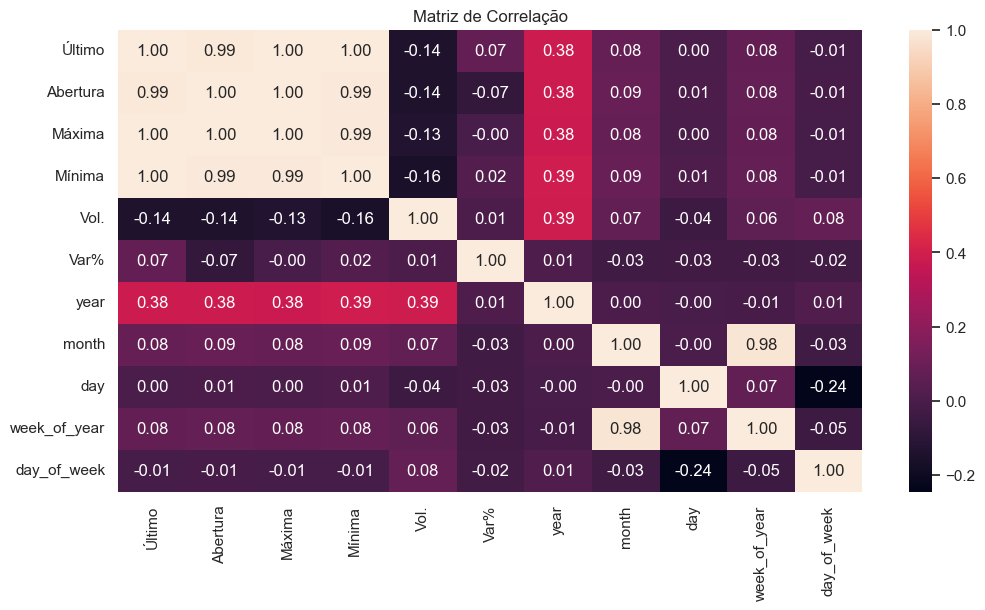

In [342]:
# Verificando a correlação entre as variáveis numéricas

plt.figure(figsize=(12,6))
num_attributes = df3.select_dtypes( include=['int64', 'float64'] )

correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True, fmt='.2f' )
plt.title('Matriz de Correlação')
plt.show()

### 3.1 H1. O Desempenho do mercado varia de acordo com o dia da semana ?
R: Sim, conforme gráficos abaixo, observamos que o mercado habitualmente fecha com o pontos mais altos as terças e sextas.

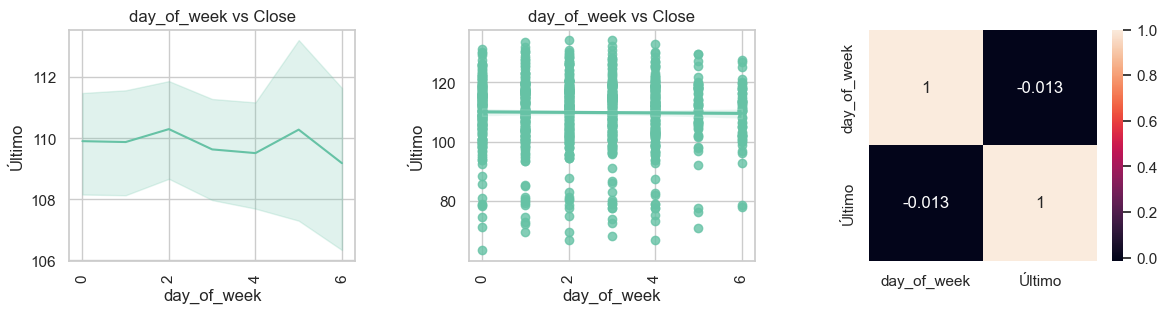

In [343]:
aux1 = df3[['day_of_week','Último']]


fig, axes = plt.subplots(1, 3, figsize=(14, 3))
plt.subplots_adjust(wspace=0.4)
#fig.delaxes(axes[1, 0])

# Plot on the first subplot (axes[0, 0])
sns.lineplot(x='day_of_week', y='Último', data=df3, ax=axes[0])
axes[0].set_title('day_of_week vs Close')
axes[0].tick_params(axis='x', rotation=90)

sns.regplot(x='day_of_week', y='Último', data=df3, ax=axes[1])
axes[1].set_title('day_of_week vs Close')
axes[1].tick_params(axis='x', rotation=90)

sns.heatmap( aux1.corr( method='pearson' ), annot=True )


plt.show()

### 3.2 H2. O Mercado apresenta padrões de sazonalidade nos meses ?
R: Sim, observamos uma correlação positiva nos meses, sendo que o ultimos meses do ano do período analisado fecham com pontos mais altos comparados aos primeiros meses do ano.

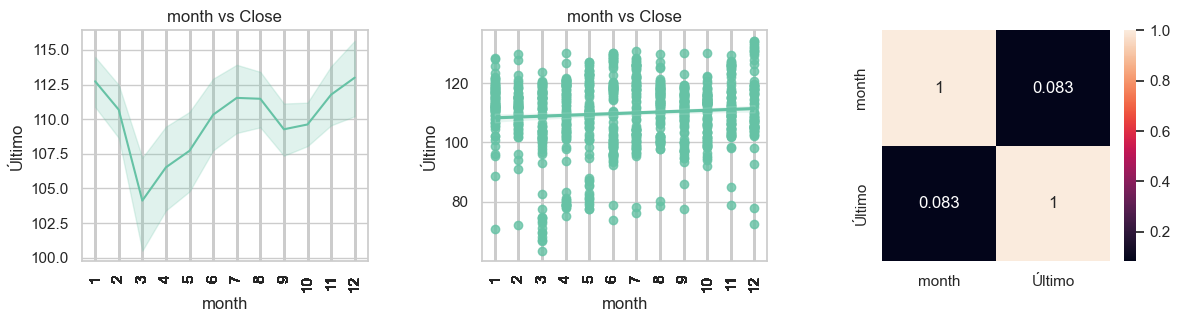

In [344]:
aux2 = df3[['month','Último']]

fig, axes = plt.subplots(1, 3, figsize=(14, 3))
plt.subplots_adjust(wspace=0.4)
#fig.delaxes(axes[1, 0])

# Plot on the first subplot (axes[0, 0])
sns.lineplot(x='month', y='Último', data=aux2, ax=axes[0])
axes[0].set_title('month vs Close')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xticks(aux2['month'])

sns.regplot(x='month', y='Último', data=aux2, ax=axes[1])
axes[1].set_title('month vs Close')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(aux2['month'])

sns.heatmap( aux2.corr( method='pearson' ), annot=True )


plt.show()

### 3.3 H3. O Desempenho do Mercado é influenciado pelo volume do dia ?
R: Sim, há uma correlação negativa, quanto mais volume de dinheiro é negociado no dia, o mercado tem uma leve tendência a fechar menor comparado aos dias com baixo volume

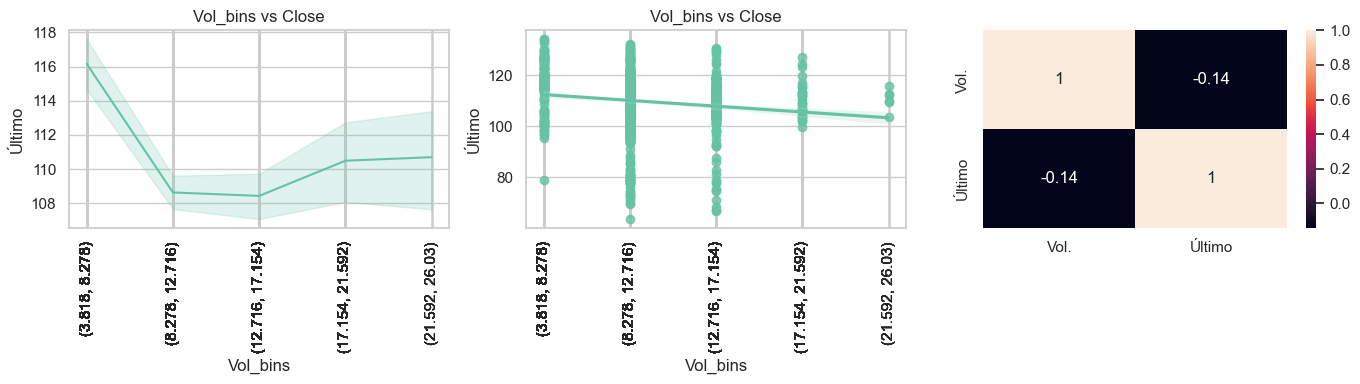

In [345]:
aux3 = df3[['Vol.','Último']]

aux3['Vol_bins'] = pd.cut(aux3['Vol.'], bins=5)
aux3['Vol_bins_cat'] = aux3['Vol_bins']
aux3['Vol_bins_cat'] = aux3['Vol_bins_cat'].astype(str).str.replace(']',')')
aux3['Vol_bins'] = aux3['Vol_bins'].cat.codes.astype(float)


# Configurar o tamanho do gráfico
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plt.subplots_adjust(wspace=0.6)

# Plotar um gráfico de linha com rótulos personalizados no primeiro subplot
sns.lineplot(x='Vol_bins', y='Último', data=aux3, ax=axes[0])
axes[0].set_title('Vol_bins vs Close')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xticks(aux3['Vol_bins'])
axes[0].set_xticklabels(aux3['Vol_bins_cat'])

# Plotar um gráfico de regressão com rótulos personalizados no segundo subplot
sns.regplot(x='Vol_bins', y='Último', data=aux3, ax=axes[1])
axes[1].set_title('Vol_bins vs Close')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(aux3['Vol_bins'])
axes[1].set_xticklabels(aux3['Vol_bins_cat'])


aux33 = df3[['Vol.','Último']]
sns.heatmap( aux33.corr( method='pearson' ), annot=True )

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()


### 3.4 H4. Qual a tendência do mercado no último ano ?

R: Observamos uma tendência de alta nos últimos 12 meses de 2023

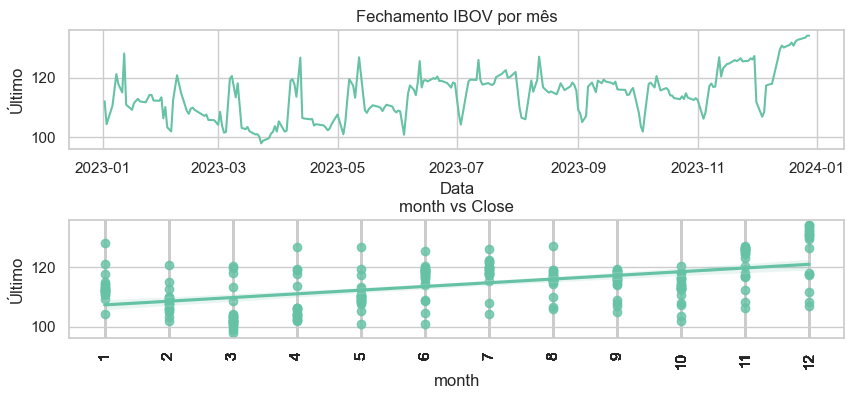

<Figure size 1500x400 with 0 Axes>

In [346]:

aux4 = df3.loc['2023-01-01':'2023-12-31']

fig, axes = plt.subplots(2, 1, figsize=(10, 4))
plt.subplots_adjust(hspace=0.6)

plt.figure(figsize=(15,4))
sns.lineplot(x=aux4.index,y='Último',data= aux4, ax=axes[0])
axes[0].set_title('Fechamento IBOV por mês')

sns.regplot(x='month', y='Último', data=aux4, ax=axes[1])
axes[1].set_title('month vs Close')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(aux4['month'])


plt.show()

#### 4.0. PASSO 04 - DATA PREPARATION

In [347]:
df4 = df3.copy()

In [348]:
df4.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,year,month,day,week_of_year,day_of_week
Data,,,,,,,,,,,
2023-12-28,134.185,134.194,134.389,133.832,7.81,-0.01,2023,12,28,52,3
2023-12-27,134.194,133.523,134.195,133.328,6.17,0.49,2023,12,27,52,2
2023-12-26,133.533,132.753,133.645,132.753,5.15,0.59,2023,12,26,52,1
2023-12-22,132.753,132.182,133.035,132.094,8.23,0.43,2023,12,22,51,4
2023-12-21,132.182,130.826,132.277,130.822,8.68,1.05,2023,12,21,51,3


## 5.1. Rescaling

In [349]:
df5 = df4.copy()

### Nesta etapa fizemos uma transformação nas colunas temporais de forma a reduzir a escala no range de 0 á 1. Essa transformação foi realizada com o intuito de melhorar a perfomance dos modelos.

### 5.3.3. Nature Transformation

In [351]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )



features = df5[['day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]

# Adicione essas características ao seu conjunto de dados original
df5 = pd.concat([df5, features], axis=1)

# Agora você podae usar df5 em seu modelo de machine learning


# 6.0. PASSO 06 - FEATURE SELECTION

In [352]:
df6 = df5.copy()
df6.columns

Index(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'year',
       'month', 'day', 'week_of_year', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos'],
      dtype='object')

## 6.1. Separando os dados em treino e teste

In [353]:
df6 = df6['Último'].reset_index()
#df6.set_index('Data', inplace=True)

df6.rename(columns={'Último': 'y','Data': 'ds'}, inplace=True)

In [355]:
# training dataset
X_train = df6[df6['ds'] < '2023-06-01']
y_train = X_train['y']

# test dataset
X_test = df6[df6['ds'] > '2023-05-31']
y_test = X_test['y']

h = X_test['ds'].nunique()
print( 'Training Min Date: {}'.format( X_train['ds'].min() ) )
print( 'Training Max Date: {}'.format( X_train['ds'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['ds'].min() ) )
print( 'Test Max Date: {}'.format( X_test['ds'].max() ) )

Training Min Date: 2020-01-04 00:00:00
Training Max Date: 2023-05-31 00:00:00

Test Min Date: 2023-06-01 00:00:00
Test Max Date: 2023-12-28 00:00:00


# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

## 7.1. Arima Model

Para o período que utilizamos , o resultado ADF nos mostrou que o p_value é 3,9% rejeitando a hipótese nula. Por esse motivo seguimos com ao treinamento e predição do modelo sem transformar a escala dos dados.

In [356]:
# teste ADF ( estacionaridade)
# Se o P Value <= 0.05 (5%) , então rejeitamos a hipótese Nula, com nível de confiança de 95%

# H0 - Hipótese Nula ( Série não é estacionária)
# H1 - Hipótese Alternativa ( Série é estacionária)
X = df5['Último'].values
result = adfuller(X)

# Resultado : Hipótese Nula Rejeitada - Apesar do teste estatístico ser maior do que os valores críticos, 
# o P-Value é de 3%, refeijando a hipótese Nula.

print('Teste ADF ')
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores Críticos :")

for key,value in result[4].items():
    print(f"\t {key}: {value}")


Teste ADF 
Teste Estatístico: -2.956384150617949
P-Value: 0.03917323700138554
Valores Críticos :
	 1%: -3.4370062675076807
	 5%: -2.8644787205542492
	 10%: -2.568334722615888


In [357]:
# Exemplo de diferenciação de primeira ordem
#X_train_diff = X_train['y'].diff().dropna()
#X_test_diff = X_test['y'].diff().dropna()

In [403]:
from pmdarima import auto_arima

# Série temporal: series
auto_model = auto_arima(X_train['y'], suppress_warnings=True)
auto_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  847
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1716.006
Date:                Sat, 20 Jan 2024   AIC                           3438.012
Time:                        11:37:49   BIC                           3452.233
Sample:                             0   HQIC                          3443.460
                                - 847                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1148      0.018     -6.364      0.000      -0.150      -0.079
ma.L2          0.1029      0.018      5.651      0.000       0.067       0.139
sigma2         3.3832      0.088     38.359      0.000       3.210       3.556
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1405.48
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [472]:
# ARIMA MODEL

#p, d, q = 1, 0, 1
p, d, q = 6, 0, 6


arima_model = ARIMA(X_train['y'], order=(p, d, q))
arima_fit = arima_model.fit()

# FIT AND PREDICT
h = h
forecast = arima_fit.get_forecast(steps=h)
forecast_values = forecast.predicted_mean

# Convertendo em DF para Merge
df_arima = pd.DataFrame(forecast_values)
X_test_a = pd.DataFrame(X_test)

# Resetando os índices

df_arima = df_arima.reset_index(drop=True).reset_index()
X_test_a = X_test_a.reset_index(drop=True).reset_index()

In [473]:
df_arima['predicted_mean'] = df_arima['predicted_mean'].round(3)
result_a = X_test_a.merge(df_arima,on='index',how='left')
result_a.head(5)

,index,ds,y,predicted_mean
0,0,2023-12-28,134.185,118.614
1,1,2023-12-27,134.194,118.651
2,2,2023-12-26,133.533,118.618
3,3,2023-12-22,132.753,118.865
4,4,2023-12-21,132.182,119.036


In [474]:
# performance
arima_result = ml_error( 'Arima Model', y_test, forecast_values )
arima_result

,Model Name,MAE,MAPE,RMSE
0,Arima Model,5.645186,0.046878,6.84541


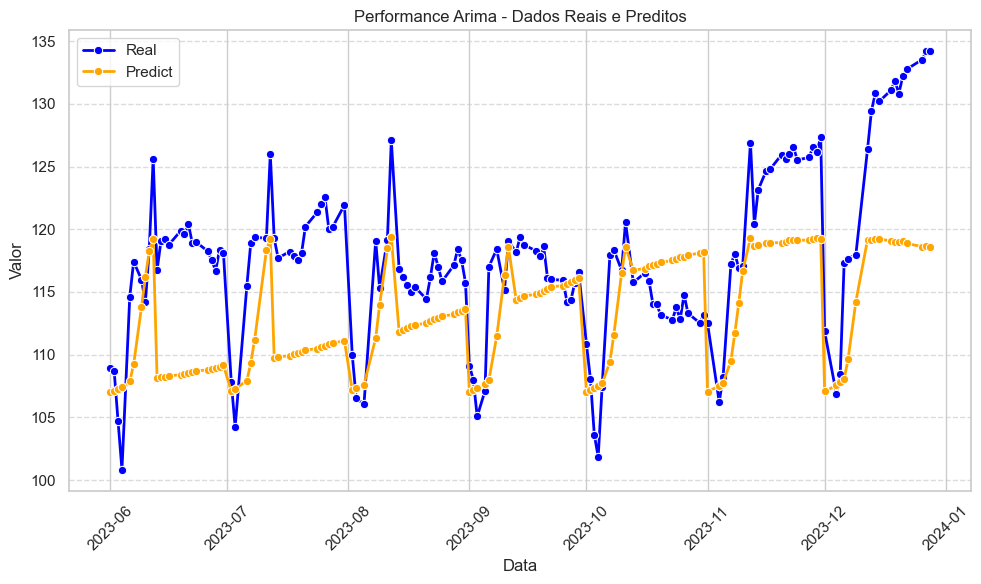

In [475]:
# Configuração do estilo do seaborn
sns.set(style='whitegrid', palette='Set2')

# Criar o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(x='ds', y='y', data=result_a, label='Real', marker='o', color='blue', linewidth=2)
sns.lineplot(x='ds', y='predicted_mean', data=result_a, label='Predict', marker='o', color='orange', linewidth=2)

# Adicionar intervalo de confiança se disponível (substitua 'ic_lower' e 'ic_upper' com seus nomes reais)
# sns.fill_between(x=result_a['ds'], y1=result_a['ic_lower'], y2=result_a['ic_upper'], color='gray', alpha=0.2, label='Confidence Interval')

# Adicionar rótulos e legendas
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Performance Arima - Dados Reais e Preditos')
plt.legend()

# Rotacionar as datas para melhorar a legibilidade
plt.xticks(rotation=45)

# Adicionar grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

## 7.2. Linear Regression Model

In [362]:
colunas_para_remover = ['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'year', 'month', 'day']
df5 = df5.drop(columns=colunas_para_remover)


In [363]:
# training dataset
X_train_lr = df5.loc[ '2020-01-01': '2023-05-31'].drop(columns='Último')
y_train_lr = df5['Último'].loc['2020-01-01': '2023-05-31']

# test dataset
X_test_lr = df5.loc[ '2023-06-01':'2023-12-31'].drop(columns='Último')
y_test_lr = df5['Último'].loc['2023-06-01' : '2023-12-31']

print( 'Training Min Date: {}'.format( X_train_lr.index.min() ) )
print( 'Training Max Date: {}'.format( X_train_lr.index.max() ) )

print( '\nTest Min Date: {}'.format( X_test_lr.index.min() ) )
print( 'Test Max Date: {}'.format( X_test_lr.index.max() ) )

Training Min Date: 2020-01-04 00:00:00
Training Max Date: 2023-05-31 00:00:00

Test Min Date: 2023-06-01 00:00:00
Test Max Date: 2023-12-28 00:00:00


In [364]:


# 1° modelo de regressão linear
modelo = LinearRegression()

# Treine o modelo no conjunto de treinamento
modelo.fit(X_train_lr, y_train_lr)

# Faça previsões no conjunto de teste
y_pred = modelo.predict(X_test_lr)

# performance
lr_result = ml_error( 'Linear Regression', y_test, y_pred )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,10.014158,0.082586,11.849991


In [365]:
df_lr = pd.DataFrame(y_pred).reset_index()
result_lr = X_test_a.merge(df_lr,on='index',how='left')
result_lr.rename(columns={0: 'lr_predict'}, inplace=True)

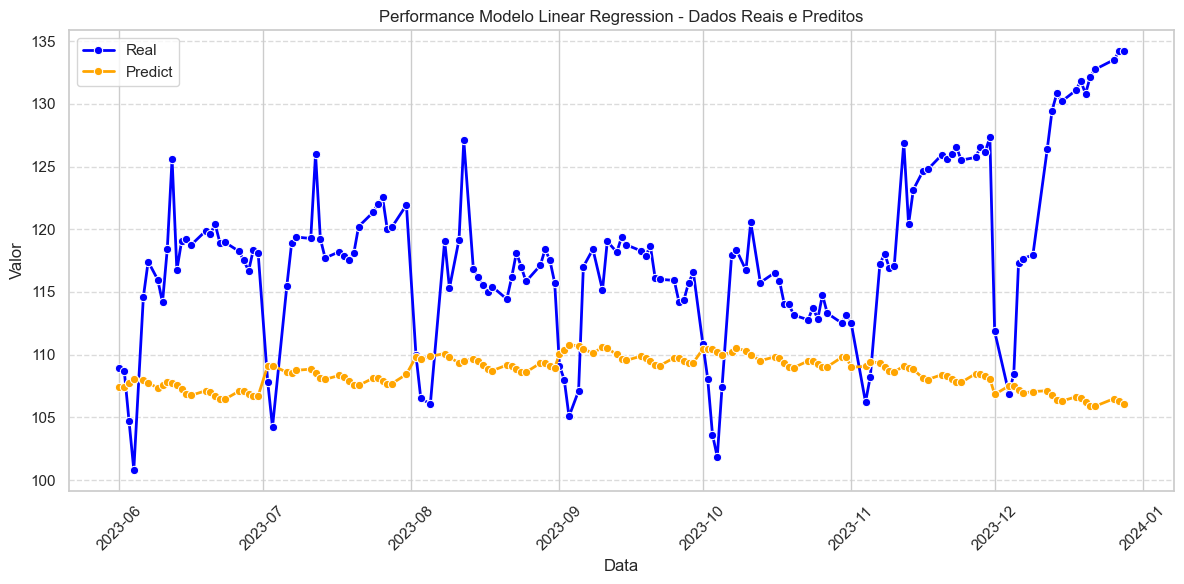

In [366]:
# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='y', data=result_lr, label='Real', marker='o', color='blue', linewidth=2)
sns.lineplot(x='ds', y='lr_predict', data=result_lr, label='Predict', marker='o', color='orange', linewidth=2)

# Adicionar intervalo de confiança se disponível (substitua 'ic_lower' e 'ic_upper' com seus nomes reais)
# sns.fill_between(x=result_a['ds'], y1=result_a['ic_lower'], y2=result_a['ic_upper'], color='gray', alpha=0.2, label='Confidence Interval')

# Adicionar rótulos e legendas
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Performance Modelo Linear Regression - Dados Reais e Preditos')
plt.legend()

# Rotacionar as datas para melhorar a legibilidade
plt.xticks(rotation=45)

# Adicionar grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

## 7.3. Decision Tree Model

In [367]:
# Criar o modelo de Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)

# Treinar o modelo no conjunto de treino
tree_model.fit(X_train_lr, y_train_lr)

# Fazer previsões no conjunto de teste
y_pred_lr = tree_model.predict(X_test_lr)

In [368]:
# performance
dt_result = ml_error( 'Decision Tree', y_test, y_pred_lr )
dt_result

,Model Name,MAE,MAPE,RMSE
0,Decision Tree,13.450313,0.112201,16.172758


In [369]:
df_dt = pd.DataFrame(y_pred_lr).reset_index()
result_dt = X_test_a.merge(df_dt,on='index',how='left')
result_dt.rename(columns={0: 'dt_predict'}, inplace=True)

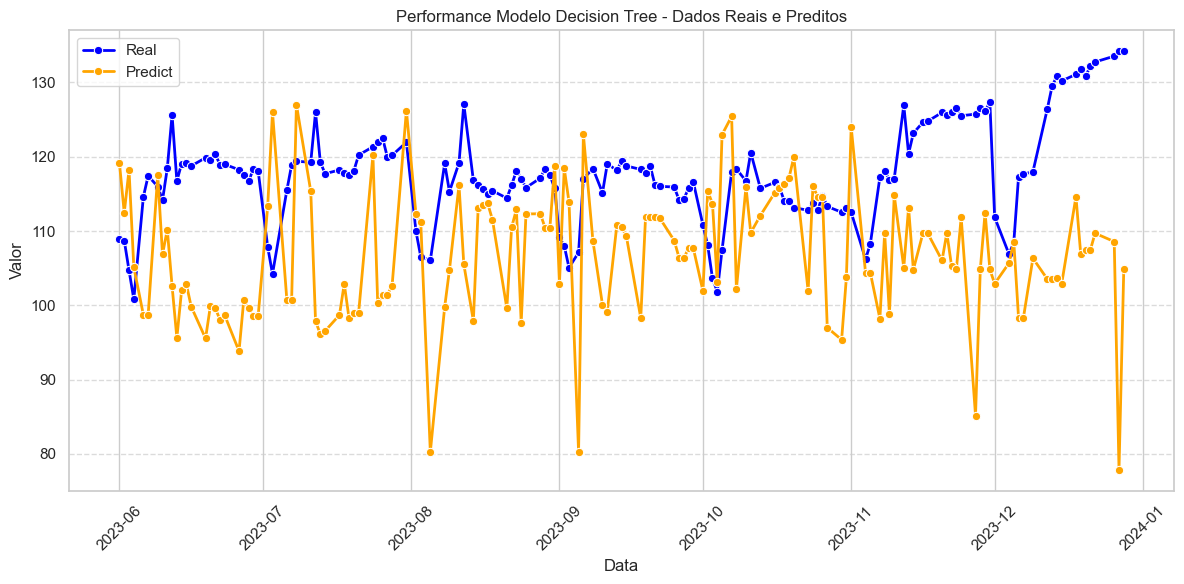

In [370]:
# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='y', data=result_dt, label='Real', marker='o', color='blue', linewidth=2)
sns.lineplot(x='ds', y='dt_predict', data=result_dt, label='Predict', marker='o', color='orange', linewidth=2)

# Adicionar intervalo de confiança se disponível (substitua 'ic_lower' e 'ic_upper' com seus nomes reais)
# sns.fill_between(x=result_a['ds'], y1=result_a['ic_lower'], y2=result_a['ic_upper'], color='gray', alpha=0.2, label='Confidence Interval')

# Adicionar rótulos e legendas
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Performance Modelo Decision Tree - Dados Reais e Preditos')
plt.legend()

# Rotacionar as datas para melhorar a legibilidade
plt.xticks(rotation=45)

# Adicionar grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

## 7.4. Random Forest Regressor

In [371]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( X_train_lr, y_train_lr )

# prediction
yhat_rf = rf.predict( X_test_lr )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test_lr ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,4.042117e+56,352.334154,2.400783e+57


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [372]:
modelling_result = pd.concat( [lr_result, arima_result, dt_result, ] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Arima Model,5.065394,0.042362,6.271715
0,Linear Regression,10.014158,0.082586,11.849991
0,Decision Tree,13.450313,0.112201,16.172758


## 9.0 Machine Learning Performance

In [375]:
df8 = result_lr.merge(result_a, on='index',how='left')
df9 = df8.merge(result_dt, on='index',how='left')

In [380]:
df9 = df9.drop(columns={'ds_y','y_y','ds','y'})
df9.rename(columns={'ds_x':'ds','y_x':'y_real','predicted_mean':'arima_predict'},inplace=True)

In [382]:
df9['error_arima'] = df9['y_real'] - df9['arima_predict']
df9['error_lr'] = df9['y_real'] - df9['lr_predict']
df9['error_dt'] = df9['y_real'] - df9['dt_predict']
df9.sample(10)

,index,ds,y_real,lr_predict,arima_predict,dt_predict,error_arima,error_lr,error_dt
114,114,2023-06-19,119.858,107.117790,113.545,95.547,6.313,12.740210,24.311
61,61,2023-09-15,118.758,109.546545,115.150,109.280,3.608,9.211455,9.478
38,38,2023-10-25,112.830,109.234388,116.154,114.626,-3.324,3.595612,-1.796
71,71,2023-08-28,117.121,109.321347,114.780,112.323,2.341,7.799653,4.798
136,136,2023-06-03,104.700,107.701268,113.088,118.228,-8.388,-3.001268,-13.528
112,112,2023-06-21,120.420,106.733584,113.591,99.685,6.829,13.686416,20.735
41,41,2023-10-20,113.155,108.970726,116.010,119.929,-2.855,4.184274,-6.774
124,124,2023-11-05,108.256,109.435138,113.325,104.397,-5.069,-1.179138,3.859
76,76,2023-08-21,114.429,109.169131,114.608,99.595,-0.179,5.259869,14.834
144,144,2023-10-01,110.817,110.469564,112.945,101.945,-2.128,0.347436,8.872


In [ ]:

sns.lineplot( x='ds', y='y', data=result_a, label='Real' )
sns.lineplot( x='ds', y='predicted_mean', data=result_a, label='Predict' )



# 10.0 Final Conclusion 

Período Utilizado :

Utilizamos os dados a partir de 2020, pois considerando a recomendação de 80/20 e 90/10, esse range de dados temporal seria suficiente para treinar o modelo para o período que definimos prever ( 6 uúltimos meses de 2023) e também é um período com poucos ruídos externos como a crise em 2008 e pandemia em 2019.


Escolha das métricas de Avaliação do erro :

Optamos por utilziar o MAE (Erro Absoluto Médio), MAPE (Erro Percentual Absoluto Médio) e RMSE (Erro Quadrático Médio da Raiz) como métricas de avaliação do erro, por ser mais apropriado para modelos de regressão e previsão de valores do que utilizar a acurácia. Pois as métricas de erro fornecem uma medida mais sensível às diferenças absolutas entre as previsões e os valores reais,enquanto a acurácia, é comumente mais utilizada para avaliação de modelos de classificação, pois é uma avaliação binária.

Modelo Vencedor : ARIMA MODEL

Conforme dados comparativos na tabela da sessão 9.0 o modelo com a menor erro ( MAE,MAPE e RMSE) foi o Arima, testamos diversos cenários para definir os parâmentros P,D,Q que performaram em um resultado de 4.68 % de erro médio percentual (MAPE). Melhor resultado comparado aos outros modelos testados ( Linear Regression e Decision Tree ).
